In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

### Data Collection

In [2]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module5_exercise_train.csv')
download_file(test_data_url, 'module5_exercise_test.csv')

Downloaded module5_exercise_train.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv
Downloaded module5_exercise_test.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv


In [3]:
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")
df_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

### Data analysis

In [4]:
#### Make a complete analysis on data preprocessing
# Inconsistencies
# Duplicates (data.duplicated().sum())
# Missing values (data.isnull().sum())
# Categorical
# Outliers
# Feature Engineering
# Feature Selection and/or Dimensionality Reduction

In [5]:
data = pd.concat([df_train, df_test], axis=0)
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
data.head()

Train shape: (1909, 16)
Test shape: (365, 15)


,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,2015-01-10,Rainy,62.701614,6.83 m/s,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,2015-01-11,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090


In [6]:
# 1.Inconsistencies
# 1.1 Inconsistencies in date
pattern_date = r'^\d{4}-\d{2}-\d{2}$'
invalid_dates = data[~data['date'].str.match(pattern_date)]
if len(invalid_dates) > 0:
    print("The number of inconsistencies:\t")
    print(invalid_dates)
else:
    print("All the dates are in the correct format")

All the dates are in the correct format


In [7]:
data['date'] = pd.to_datetime(data['date'])

In [8]:
data

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,2015-01-10,Rainy,62.701614,6.83 m/s,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,2015-01-11,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,Snowy,71.521673,22.78 km/h,Moderate,-1.674798,-2.338987,-1.829170,-0.881428,-0.571347,-2.231680,-1.962735,-1.602805,-1.264779,-1.705180,NaN
361,2019-12-28,Sunny,67.220123,18.33 km/h,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638,NaN
362,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,NaN
363,2019-12-30,Cloudy,65.877214,7.67 m/s,Moderate,NaN,0.700484,NaN,-0.407440,-0.580917,-0.444730,0.034229,0.021199,-0.864657,NaN,NaN


In [9]:
# 1.2 Inconsistencies in wind_speed
data['wind_speed']

0      27.74 km/h
1      21.78 km/h
2        6.83 m/s
3        5.79 m/s
4      25.14 km/h
          ...    
360    22.78 km/h
361    18.33 km/h
362      7.24 m/s
363      7.67 m/s
364    30.99 km/h
Name: wind_speed, Length: 2274, dtype: object

In [10]:
# 2.Duplicates
print("The number of duplicates:", data.duplicated().sum())
data[data.duplicated(keep=False)]

The number of duplicates: 90


,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
5,2015-01-13,Cloudy,58.649834,28.75 km/h,High,-5.037719,-4.891658,-4.655657,-5.545906,NaN,-5.323173,-5.771092,NaN,-4.554718,-4.719306,303.623789
6,2015-01-13,Cloudy,58.649834,28.75 km/h,High,-5.037719,-4.891658,-4.655657,-5.545906,NaN,-5.323173,-5.771092,NaN,-4.554718,-4.719306,303.623789
51,2015-02-27,Snowy,61.321278,11.61 km/h,Moderate,-0.765329,-1.089098,-0.272114,-1.010996,-1.117890,-0.483191,-1.151202,-0.835624,NaN,NaN,315.651282
52,2015-02-27,Snowy,61.321278,11.61 km/h,Moderate,-0.765329,-1.089098,-0.272114,-1.010996,-1.117890,-0.483191,-1.151202,-0.835624,NaN,NaN,315.651282
58,2015-03-05,Cloudy,54.187891,1.02 m/s,Very Low,11.442087,12.320326,10.781174,10.926194,11.684710,11.934129,11.126555,11.184591,12.166137,11.424691,227.826146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,2019-12-11,NaN,61.201308,27.61 km/h,Moderate,0.743648,1.006100,NaN,0.593362,0.851021,0.336086,0.934330,NaN,NaN,0.879479,301.559770
1892,2019-12-17,Snowy,65.362283,5.21 m/s,Moderate,-2.380559,-2.727055,-2.769237,NaN,-1.560074,-2.888126,NaN,NaN,-2.474213,-2.380799,290.157907
1893,2019-12-17,Snowy,65.362283,5.21 m/s,Moderate,-2.380559,-2.727055,-2.769237,NaN,-1.560074,-2.888126,NaN,NaN,-2.474213,-2.380799,290.157907
1905,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,266.231273


In [11]:
# 3. Missing values
data.isnull().sum()

date                           0
weather_condition             28
humidity                     109
wind_speed                   107
oil_brent_price_indicator      0
temperature_station1         344
temperature_station2         328
temperature_station3         340
temperature_station4         320
temperature_station5         337
temperature_station6         321
temperature_station7         361
temperature_station8         336
temperature_station9         350
temperature_station10        367
electricity_demand           365
dtype: int64

In [12]:
# 4. Categorical
# 4.1 weather_condition
data['weather_condition'].value_counts()

weather_condition
Rainy     683
Sunny     681
Cloudy    669
Snowy     213
Name: count, dtype: int64

In [13]:
# 4.2 oil_brent_price_indicator	
data['oil_brent_price_indicator'].value_counts()

oil_brent_price_indicator
Moderate     837
High         687
Low          435
Very High    239
Very Low      76
Name: count, dtype: int64

In [14]:
# 5. Outliers
data.describe()

,date,humidity,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
count,2274,2165.000000,1930.000000,1946.000000,1934.000000,1954.000000,1937.000000,1953.000000,1913.000000,1938.000000,1924.000000,1907.000000,1909.000000
mean,2017-11-01 19:20:06.332453888,107.035790,13.396383,13.077731,13.199494,13.310531,13.312156,13.301409,13.296276,13.350021,13.484352,13.331970,106.378555
min,2015-01-08 00:00:00,32.814149,-12.819683,-12.316331,-12.904753,-12.783663,-9.513493,-12.873628,-12.752546,-13.213493,-13.369174,-12.360144,-223288.771683
25%,2016-07-07 06:00:00,54.128279,5.489321,4.987520,5.204434,5.219280,5.240711,5.380471,5.499581,5.322248,5.585514,5.305135,185.065853
50%,2017-12-28 12:00:00,62.208706,12.865173,12.693993,12.704200,12.911890,12.810285,12.799441,12.795622,13.067600,12.846059,12.872528,214.482125
75%,2019-03-30 18:00:00,68.142186,22.857480,21.740908,22.198554,22.474576,22.512605,22.321765,22.393285,22.018201,22.646406,22.439541,257.229149
max,2019-12-31 00:00:00,50000.000000,35.456648,37.267279,37.727810,38.133324,38.471490,38.588948,37.769152,38.098873,38.470479,37.651955,387.741952
std,NaN,1517.524083,10.775543,10.772682,10.782193,10.817318,10.775815,10.796030,10.755605,10.763963,10.776536,10.796021,5115.886615


In [15]:
def plot_feature_over_time(df, feature, date_id_start, date_id_end):
    df_filtered = df[(df['date'] >= date_id_start) & (df['date'] <= date_id_end)]
    
    if feature not in df_filtered.columns:
        print(f"Feature '{feature}' not found in the DataFrame.")
        return
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['date'], df_filtered[feature], label=feature, linestyle='-')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} from {date_id_start} to {date_id_end}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

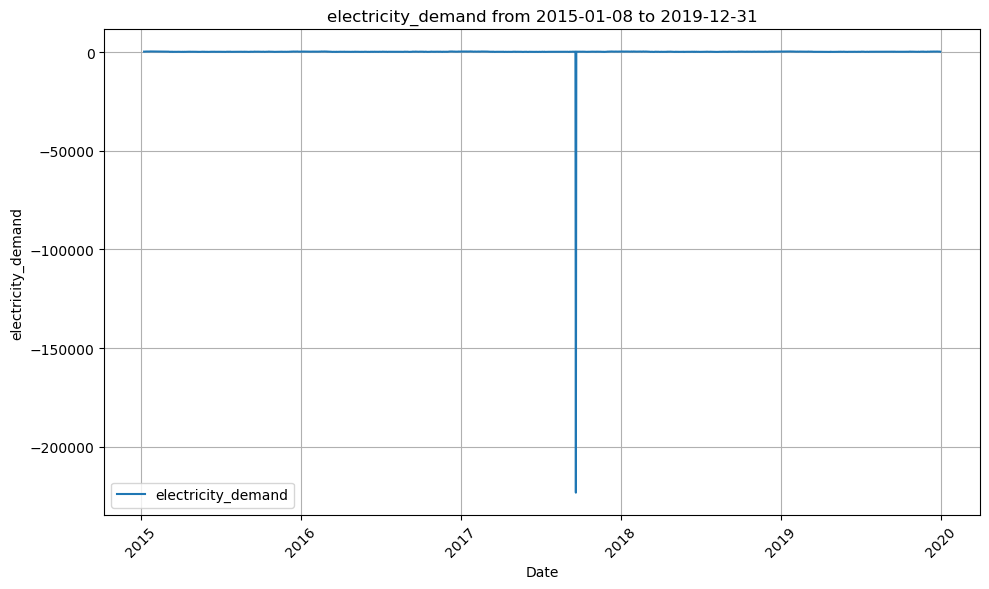

In [16]:
# 5.1 electricity_demand
plot_feature_over_time(data, 'electricity_demand', '2015-01-08', '2019-12-31')
# 2017-09-20 has the outlier of electricity_demand.

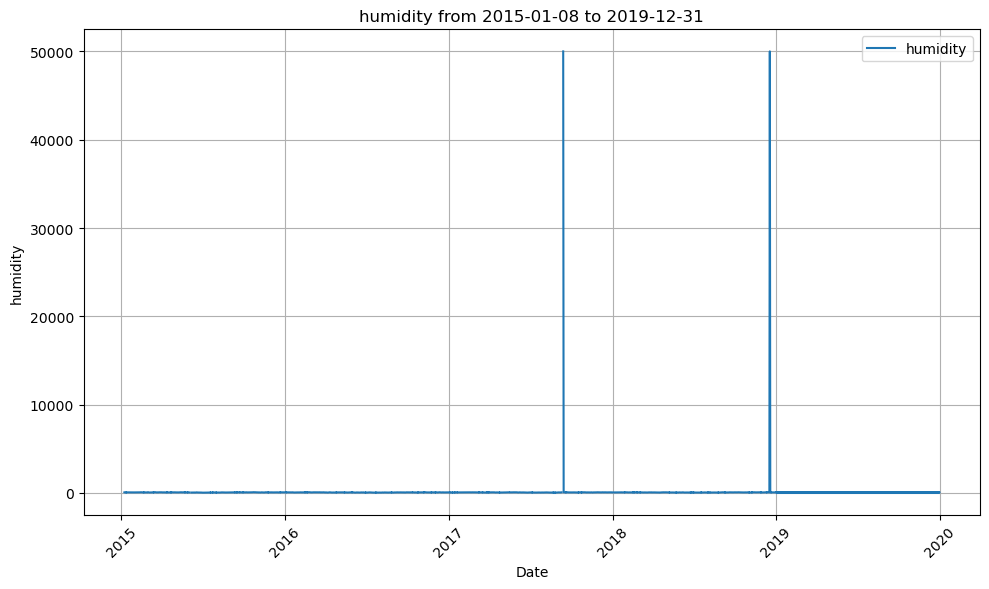

In [17]:
# 5.2 humidity
plot_feature_over_time(data, 'humidity', '2015-01-08', '2019-12-31')
# This contains 2 outliers.
# 2017-09-13 and 2018-12-18

### Data Preprocessing Evaluation Strategy

In [18]:
# Provide a complete data preprocessing transformations

In [33]:
# 1. Handle Inconsistencies
def handle_inconsistencies(X_train, y_train, X_val=None):
    def handle_windspeed(windspeed):
        windspeed = str(windspeed).strip()
        if "km/h" in windspeed:
            speed = float(windspeed.replace("km/h", "").strip())
        elif "m/s" in windspeed:
            speed = float(windspeed.replace("m/s", "").strip()) * 3.6  
        else:
            speed = float(windspeed)
        return speed
    if X_val is not None:
        X_train['wind_speed'] = X_train['wind_speed'].apply(handle_windspeed)
        X_val['wind_speed'] = X_val['wind_speed'].apply(handle_windspeed)
        return X_train, y_train, X_val
    else:
        X_train['wind_speed'] = X_train['wind_speed'].apply(handle_windspeed)
        return X_train, y_train


# 2. Handling Duplicates
def handle_duplicates(X_train, y_train, X_val=None):
    X_train_no_duplicates = X_train.copy()
    y_train_no_duplicates = y_train.copy()
    X_train_no_duplicates = X_train_no_duplicates.drop_duplicates()
    y_train_no_duplicates = y_train_no_duplicates.loc[X_train_no_duplicates.index]
    if X_val is not None:
        return X_train_no_duplicates, y_train_no_duplicates, X_val
    else:
        return X_train_no_duplicates, y_train_no_duplicates


# 3. Handling Missing Values
def handle_missing_values(X_train, y_train, X_val=None):
    # X_train['weather_condition'] = X_train['weather_condition'].fillna('Unknown')
    features = ['humidity', 'wind_speed', 'temperature_station1',
       'temperature_station2', 'temperature_station3', 'temperature_station4',
       'temperature_station5', 'temperature_station6', 'temperature_station7',
       'temperature_station8', 'temperature_station9', 'temperature_station10']
    X_train[features] = X_train[features].ffill()
    if X_val is not None:
        X_val['weather_condition'] = X_val['weather_condition'].fillna('Unknown')
        X_val[features] = X_val[features].ffill()
        return X_train, X_val
    else:
        return X_train

# 4. Handling Categorical Values
def handle_categorical(X_train, y_train, X_val=None):
    mapping = {'Very Low': 0, 'Low': 1, 'Moderate': 2, 'High': 3, 'Very High': 4}
    X_train_encoded = pd.get_dummies(X_train.copy(), columns=['weather_condition'], dummy_na=False)
    X_train_encoded['oil_brent_price_indicator'] = X_train_encoded['oil_brent_price_indicator'].map(mapping)
    if X_val is not None:
        X_val_encoded = pd.get_dummies(X_val.copy(), columns=['weather_condition'], dummy_na=False)
        X_val_encoded['oil_brent_price_indicator'] = X_val_encoded['oil_brent_price_indicator'].map(mapping)
        X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
        return X_train_encoded, X_val_encoded
    else:
        return X_train_encoded

# 5. Handling Outliers
def handle_outliers(X_train, y_train, X_val=None):
    def IQR(df, columns):
        for column in columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[column] = np.clip(df[column], lower_bound, upper_bound)
        return df
    def handle_y_outliers(y):
        Q1 = y.quantile(0.25)
        Q3 = y.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return np.clip(y, lower_bound, upper_bound)
    column1 = ['humidity']
    # column2 = ['electricity_demand']
    X_train = IQR(X_train.copy(), column1)
    y_train = handle_y_outliers(y_train.copy())
    if X_val is not None:
        X_val = IQR(X_val.copy(), column1)
        return X_train, y_train, X_val
    else:
        return X_train, y_train

# 6. Feature Engineering
def feature_engineering(X_train, y_train, X_val=None):
    def datatime(df):
        df['date'] = pd.to_datetime(df['date'])
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        return df
    X_train = datatime(X_train.copy())
    if X_val is not None:
        X_val = datatime(X_val.copy())
        return X_train, y_train, X_val
    else:
        return X_train, y_train

# 7. Feature Selection and Dimensionality Reduction
def feature_selection(X_train, X_val=None):
    selected_columns = ['humidity', 'temperature_station1',
       'temperature_station2', 'temperature_station3', 'temperature_station4',
       'temperature_station5', 'temperature_station6', 'temperature_station7',
       'temperature_station8', 'temperature_station9', 'temperature_station10',
       'year', 'month', 'day', 'oil_brent_price_indicator', 'weather_condition_Cloudy',
       'weather_condition_Sunny', 'weather_condition_Rainy', 'weather_condition_Snowy']
    X_train_selected = X_train[selected_columns]
    if X_val is not None:
        X_val_selected = X_val[selected_columns]
        return X_train_selected, X_val_selected
    else:
        return X_train_selected

In [20]:
!pip install xgboost

In [36]:
from xgboost import XGBRegressor
def evaluate_pipeline(X, y, n_splits=5):

    ### call transformations here, if there is no learning and no need to be crossval
    X, y = handle_inconsistencies(X, y)
    X, y = handle_duplicates(X, y)
    X = handle_missing_values(X, y)
    X = handle_categorical(X, y)
    X, y = handle_outliers(X, y)
    X, y = feature_engineering(X, y)
    X = feature_selection(X)
    
    model = XGBRegressor()
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    train_scores = []
    val_scores = []
    
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"Processing fold {fold + 1}/{n_splits}...")
        
        # Split data into train and validation sets
        X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
        y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

        # ### call transformations here, if there is learning
        # # X_train, y_train, X_val = handle_inconsistencies(X_train, y_train, X_val)
        # X_train, y_train, X_val = handle_duplicates(X_train, y_train, X_val)
        # # X_train, X_val = handle_missing_values(X_train, y_train, X_val)
        # X_train, X_val = handle_categorical(X_train, y_train, X_val)
        # # X_train, y_train, X_val = handle_outliers(X_train, y_train, X_val)
        # X_train, y_train, X_val = feature_engineering(X_train, y_train, X_val)
        # # X_train, X_val = feature_selection(X_train, y_train, X_val)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_scores.append(train_mse)
        
        # Predict on validation set
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_scores.append(val_mse)
        
        print(f"Fold {fold + 1} Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
    
    # Compute mean, max, and min values for train and validation MSE
    mean_train_mse = np.mean(train_scores)
    max_train_mse = np.max(train_scores)
    min_train_mse = np.min(train_scores)
    
    mean_val_mse = np.mean(val_scores)
    max_val_mse = np.max(val_scores)
    min_val_mse = np.min(val_scores)
    
    # Print results
    print("\nTrain MSE:")
    print(f"Mean: {mean_train_mse:.4f}, Max: {max_train_mse:.4f}, Min: {min_train_mse:.4f}")
    
    print("\nValidation MSE:")
    print(f"Mean: {mean_val_mse:.4f}, Max: {max_val_mse:.4f}, Min: {min_val_mse:.4f}")
    
    return mean_val_mse  # Return mean validation MSE as the overall score

In [37]:
# Prepare X and y
X = df_train.copy().drop(columns=['electricity_demand'], axis=1)
y = df_train.copy().pop('electricity_demand')

# Run the evaluation
evaluate_pipeline(X, y)

Processing fold 1/5...
Fold 1 Train MSE: 0.0014, Validation MSE: 521.5867
Processing fold 2/5...
Fold 2 Train MSE: 0.1368, Validation MSE: 468.2037
Processing fold 3/5...
Fold 3 Train MSE: 0.9298, Validation MSE: 564.1418
Processing fold 4/5...
Fold 4 Train MSE: 2.2237, Validation MSE: 446.8065
Processing fold 5/5...
Fold 5 Train MSE: 4.4555, Validation MSE: 520.7118

Train MSE:
Mean: 1.5494, Max: 4.4555, Min: 0.0014

Validation MSE:
Mean: 504.2901, Max: 564.1418, Min: 446.8065


np.float64(504.29007992444383)

### Generating Submission File

In [38]:
# Train and submit your results

In [39]:
# Prepare X_train and y_train from your data
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")

X_train = df_train.drop(columns=['electricity_demand'], axis=1)
y_train = df_train['electricity_demand']

X_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

In [40]:
def train_and_predict_to_submit(X_train, y_train, X_test):
    model = XGBRegressor()
    
    X_train, y_train, X_test = handle_inconsistencies(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_duplicates(X_train, y_train, X_test)
    X_train, X_test = handle_missing_values(X_train, y_train, X_test)
    X_train, X_test = handle_categorical(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_outliers(X_train, y_train, X_test)
    X_train, y_train, X_test = feature_engineering(X_train, y_train, X_test)
    X_train, X_test = feature_selection(X_train, X_test)

    # Train the model on the entire training set
    print(f"Training model on entire dataset of shape: {X_train.shape}")
    model.fit(X_train, y_train)
    
    # Predict on the test set
    print(f"Predicting on test dataset of shape: {X_test.shape}")
    y_test_pred = model.predict(X_test)
    
    return y_test_pred

In [41]:
# Call serve_model to train and predict
y_test_pred = train_and_predict_to_submit(X_train, y_train, X_test)

Training model on entire dataset of shape: (1819, 19)
Predicting on test dataset of shape: (365, 19)


In [42]:
# Generating Submission File
submission = pd.DataFrame({
    'date': X_test['date'],
    'electricity_demand': y_test_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False, sep=',')
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.
